### Imports necesarios

In [1]:
# Útiles
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Splitear la weá.
from sklearn.model_selection import train_test_split


In [2]:
# Global variables
cutsAmount = 5

### Read the data for the first time

In [3]:
dataSetWine = pd.read_csv("./winequality-red.csv")
dataSetWine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Quality distribution
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Low quality rate [3-5]: 0.465291%
High quality rate [6-8]: 0.534709%



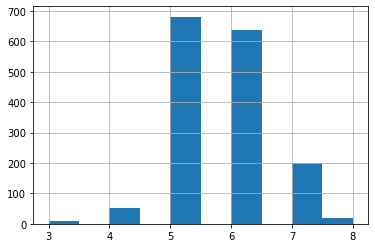

In [4]:
# Contar cuántos vinos hay en cada categoría.
print('Quality distribution')
quality = dataSetWine['quality'].value_counts()
print(quality)
print()

# Como vamos a agrupar los vinos en dos categorías (malos de 3 a 6, buenos de 6 a 9) contamos todos
#   los vinos que entren en cada categoría para saber si los datos están sesgados hacia alguna de las
#   dos categorías.
lowQualityCount = sum([quality[i] for i in range(3, 6)]) / len(dataSetWine)
highQualityCount = sum([quality[i] for i in range(6, 9)]) / len(dataSetWine)
print('Low quality rate [3-5]: {0:f}%'.format(lowQualityCount))
print('High quality rate [6-8]: {0:f}%'.format(highQualityCount))
print()

# Histograma según la calidad, para visualizar los datos.
dataSetWine['quality'].hist()
plt.show()

# En este punto notamos que los datos están sesgados hacio los vinos de alta calidad, ya que hay más
#   por lo que decidimos utilizar estratificación más adelante para crear los conjuntos de prueba y
#   entrenamiento en la misma proporción.

### Create the labels.
We are going to create a vector filled with 0's and 1's based in the quality.

In [5]:
# Put in the vector a 1 if the quality is greather tan 5, put a 0 otherwise.
Y = [int(dataSetWine['quality'][i] > 5) for i in range(len(dataSetWine))]

# Print the first 10 values and the created labels.
print('Raw quality values:', dataSetWine['quality'].values[:10])
print('New labels based on the quality values:', str(Y[:10]).replace(', ', ' '))

Raw quality values: [5 5 5 6 5 5 5 7 7 5]
New labels based on the quality values: [0 0 0 1 0 0 0 1 1 0]


# Feature Enginneering
Para comenzar vamos a elimiar la columna llamada 'quality', ya que creamos nuestros propios labels en base a esta columna

In [6]:
# How the data looks now.
print('Actual data:')

dataSetWine.head()

Actual data:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# How the data looks with the changes.
print('New data (with \'quality\' column removed and the new column added):')

# Remove the 'quality' column.
dataSetWine.drop('quality', axis = 1, inplace = True)
# Add the new column, based on the labels created previously.
dataSetWine['classification'] = Y
dataSetWine.head()


New data (with 'quality' column removed and the new column added):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,classification
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


## First experiment: normalize data
For the first experiment we are just going to normalize the data as feature engineering.

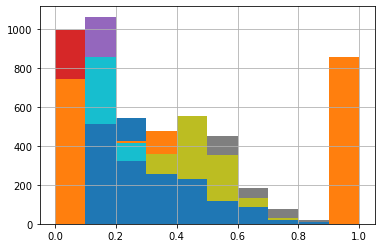

In [8]:
# Store the current labels to asign them later.
dataSetWineLabels = dataSetWine['classification']

# Normalize the data using min max scaler.
dataSetWineValues = dataSetWine.values
dataSetNormalized = preprocessing.MinMaxScaler().fit_transform(dataSetWineValues)

# Create a new pandas datta frame and reasing the 'classification' column, to prevent this for be normalized.
dataSetNormalized = pd.DataFrame(dataSetNormalized, columns=dataSetWine.columns)
dataSetNormalized['classification'] = dataSetWineLabels

# View the normalized data.
for feature in dataSetNormalized.columns:
    
    dataSetNormalized[feature].hist()
    # Descomentar las siguientes lineas para ver los histogramas individuales
    # plt.title(feature)
    # plt.show()

## Second experiment: standardize data
For the first experiment we are just going to standardize the data as feature engineering.

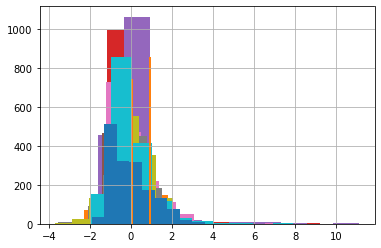

In [9]:
# Store the current labels to asign them later.
dataSetWineLabels = dataSetWine['classification']

# Standardize the data using standar scaler.
dataSetWineValues = dataSetWine.values
dataSetStandardized = preprocessing.StandardScaler().fit_transform(dataSetWineValues)

# Create a new pandas datta frame and reasing the 'classification' column, to prevent this for be standardized.
dataSetStandardized = pd.DataFrame(dataSetStandardized, columns=dataSetWine.columns)
dataSetStandardized['classification'] = dataSetWineLabels

# View the normalized data.
for feature in dataSetStandardized.columns:
    
    dataSetStandardized[feature].hist()
    # Descomentar las siguientes lineas para ver los histogramas individuales
    # plt.title(feature)
    # plt.show()

## Third experiment: better feature engineering

### Check missing values
All features are OK!

In [10]:
# Get the info of the data, to search if there is null values.
dataSetWine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  classification        1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Delete outliers
We are going to remove outliers with the quantile technique

In [11]:
# Get a copy to work and let the original data frame intact.
dataSetBetterFE = dataSetWine.copy()

# Describe the quantils for each features
dataSetBetterFE.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,classification
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.534709
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


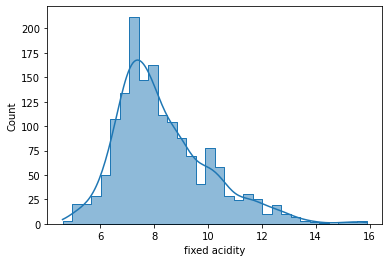

In [12]:
sns.histplot(dataSetBetterFE['fixed acidity'], kde=True, element='step')
plt.show()

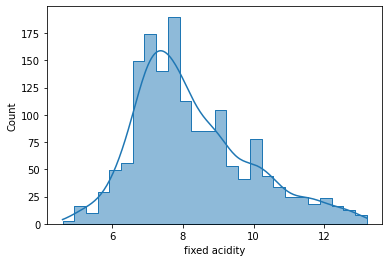

In [13]:
q = dataSetBetterFE['fixed acidity'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['fixed acidity'] < q]

sns.histplot(dataSetBetterFE['fixed acidity'], kde=True, element='step')
plt.show()

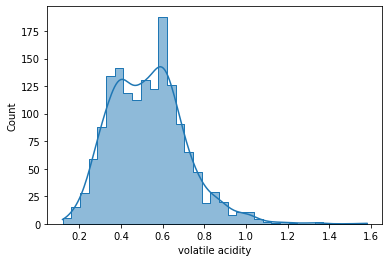

In [14]:
sns.histplot(dataSetBetterFE['volatile acidity'], kde=True, element='step')
plt.show()

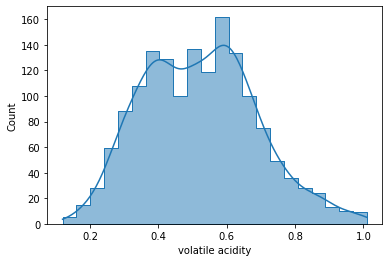

In [15]:
q = dataSetBetterFE['volatile acidity'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['volatile acidity'] < q]

sns.histplot(dataSetBetterFE['volatile acidity'], kde=True, element='step')
plt.show()

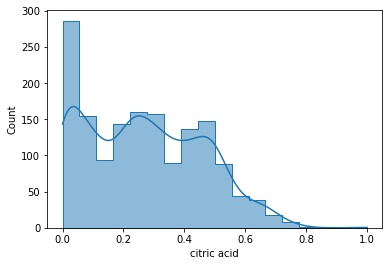

In [16]:
sns.histplot(dataSetBetterFE['citric acid'], kde=True, element='step')
plt.show()

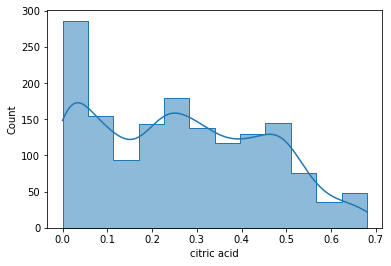

In [17]:
q = dataSetBetterFE['citric acid'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['citric acid'] < q]

sns.histplot(dataSetBetterFE['citric acid'], kde=True, element='step')
plt.show()

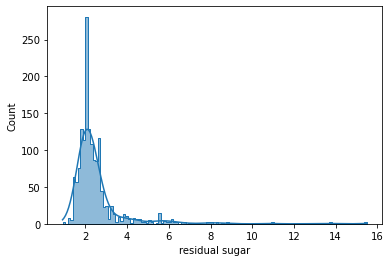

In [18]:
sns.histplot(dataSetBetterFE['residual sugar'], kde=True, element='step')
plt.show()

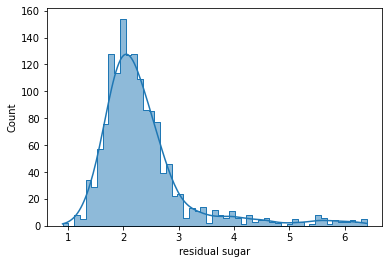

In [19]:
q = dataSetBetterFE['residual sugar'].quantile(0.98)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['residual sugar'] < q]

sns.histplot(dataSetBetterFE['residual sugar'], kde=True, element='step')
plt.show()

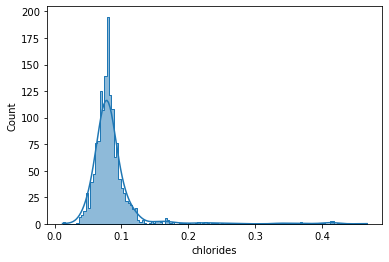

In [20]:
sns.histplot(dataSetBetterFE['chlorides'], kde=True, element='step')
plt.show()

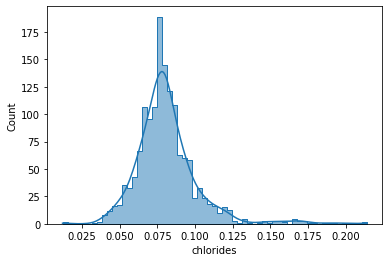

In [21]:
q = dataSetBetterFE['chlorides'].quantile(0.98)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['chlorides'] < q]

sns.histplot(dataSetBetterFE['chlorides'], kde=True, element='step')
plt.show()

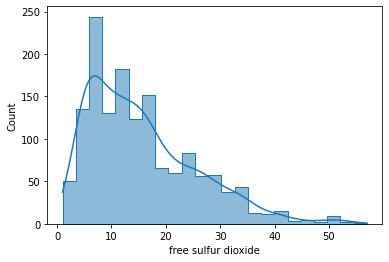

In [22]:
sns.histplot(dataSetBetterFE['free sulfur dioxide'], kde=True, element='step')
plt.show()

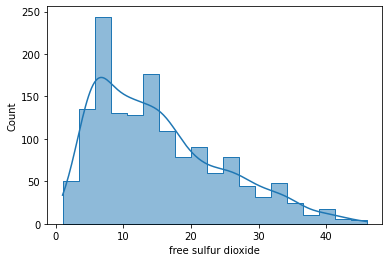

In [23]:
q = dataSetBetterFE['free sulfur dioxide'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['free sulfur dioxide'] < q]

sns.histplot(dataSetBetterFE['free sulfur dioxide'], kde=True, element='step')
plt.show()

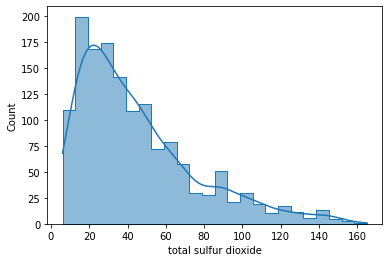

In [24]:
sns.histplot(dataSetBetterFE['total sulfur dioxide'], kde=True, element='step')
plt.show()

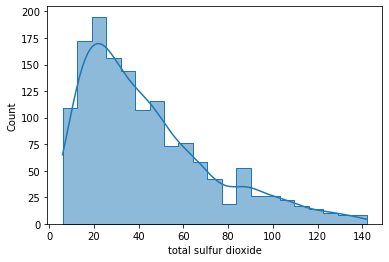

In [25]:
q = dataSetBetterFE['total sulfur dioxide'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['total sulfur dioxide'] < q]

sns.histplot(dataSetBetterFE['total sulfur dioxide'], kde=True, element='step')
plt.show()

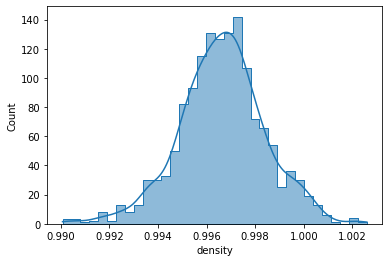

In [26]:
sns.histplot(dataSetBetterFE['density'], kde=True, element='step')
plt.show()

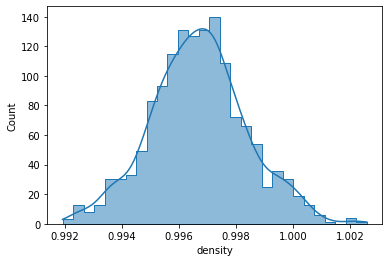

In [27]:
q = dataSetBetterFE['density'].quantile(0.01)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['density'] > q]

sns.histplot(dataSetBetterFE['density'], kde=True, element='step')
plt.show()

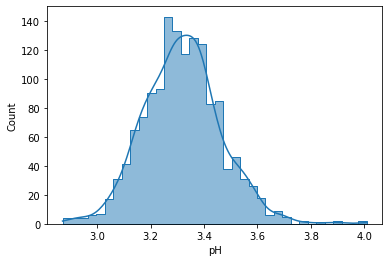

In [28]:
sns.histplot(dataSetBetterFE['pH'], kde=True, element='step')
plt.show()

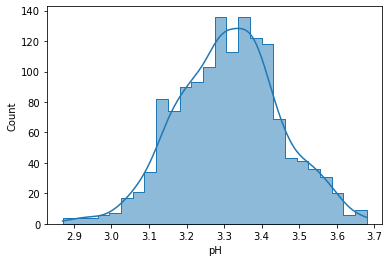

In [29]:
q = dataSetBetterFE['pH'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['pH'] < q]

sns.histplot(dataSetBetterFE['pH'], kde=True, element='step')
plt.show()

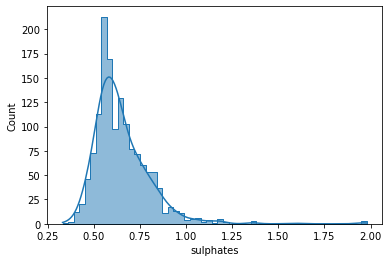

In [30]:
sns.histplot(dataSetBetterFE['sulphates'], kde=True, element='step')
plt.show()

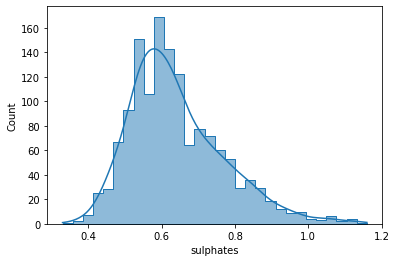

In [31]:
q = dataSetBetterFE['sulphates'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['sulphates'] < q]

sns.histplot(dataSetBetterFE['sulphates'], kde=True, element='step')
plt.show()

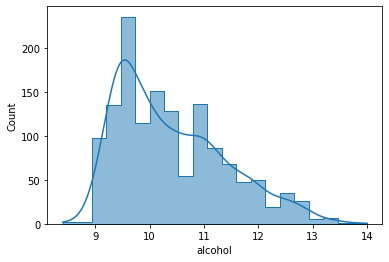

In [32]:
sns.histplot(dataSetBetterFE['alcohol'], kde=True, element='step')
plt.show()

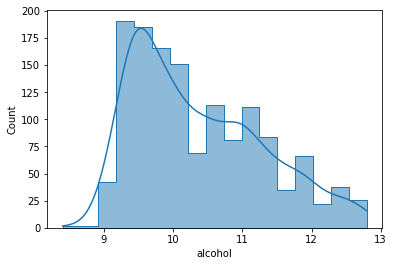

In [33]:
q = dataSetBetterFE['alcohol'].quantile(0.99)
dataSetBetterFE = dataSetBetterFE[dataSetBetterFE['alcohol'] < q]

sns.histplot(dataSetBetterFE['alcohol'], kde=True, element='step')
plt.show()

In [34]:
dataSetWine.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,classification
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.534709
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


In [35]:
dataSetBetterFE.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,classification
count,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000
mean,8.301012,0.521900,0.261098,2.367666,0.081401,15.106936,43.119220,0.996737,3.314776,0.640000,10.363283,0.536127
std,1.578383,0.166182,0.184977,0.829511,0.019858,9.266761,28.314566,0.001635,0.134419,0.128014,0.952022,0.498873
min,5.200000,0.120000,0.000000,1.200000,0.038000,1.000000,6.000000,0.991910,2.880000,0.330000,8.400000,0.000000
25%,7.175000,0.390000,0.090000,1.900000,0.071000,7.000000,21.000000,0.995640,3.220000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,36.000000,0.996700,3.320000,0.620000,10.100000,1.000000
75%,9.200000,0.631250,0.420000,2.512500,0.089000,21.000000,58.000000,0.997740,3.400000,0.710000,11.000000,1.000000
max,13.200000,1.010000,0.680000,6.400000,0.214000,46.000000,142.000000,1.002600,3.680000,1.160000,12.800000,1.000000


### Detecting multicollinearity

Using variable inflation factors to determine multicollinearity and then eliminate these correlated features


https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [36]:
# Get the columns needed to calculate the vif
variables = dataSetBetterFE[[
       'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
constants = add_constant(variables)

# Calculate the vif and store the values in a pandas data frame to display it.
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(constants.values, i) for i in range (constants.shape[1])]
vif['features'] = constants.columns
vif

,VIF,features
0,2.068174e+06,const
1,7.310337e+00,fixed acidity
2,1.939469e+00,volatile acidity
3,3.102996e+00,citric acid
4,1.584578e+00,residual sugar
5,1.154912e+00,chlorides
6,2.018584e+00,free sulfur dioxide
7,2.297769e+00,total sulfur dioxide
8,5.758717e+00,density
9,2.997727e+00,pH


In [37]:
# Drop the 'fixed acidity' and 'density' features, because they have a high vif.
dataSetBetterFE = dataSetBetterFE.drop(['fixed acidity', 'density'], axis=1)

In [38]:
dataSetBetterFE.describe()

,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,classification
count,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000
mean,0.521900,0.261098,2.367666,0.081401,15.106936,43.119220,3.314776,0.640000,10.363283,0.536127
std,0.166182,0.184977,0.829511,0.019858,9.266761,28.314566,0.134419,0.128014,0.952022,0.498873
min,0.120000,0.000000,1.200000,0.038000,1.000000,6.000000,2.880000,0.330000,8.400000,0.000000
25%,0.390000,0.090000,1.900000,0.071000,7.000000,21.000000,3.220000,0.550000,9.500000,0.000000
50%,0.520000,0.250000,2.200000,0.079000,13.000000,36.000000,3.320000,0.620000,10.100000,1.000000
75%,0.631250,0.420000,2.512500,0.089000,21.000000,58.000000,3.400000,0.710000,11.000000,1.000000
max,1.010000,0.680000,6.400000,0.214000,46.000000,142.000000,3.680000,1.160000,12.800000,1.000000


### Standardize the data

In [39]:
# Store the current labels to asign them later.
dataSetBetterFELabels = dataSetBetterFE['classification'].values

# Standardize the data using standar scaler.
dataSetBetterFEValues = dataSetBetterFE.values
dataSetBetterFEStandardized = preprocessing.StandardScaler().fit_transform(dataSetBetterFEValues)

# Create a new pandas data frame and reasing the 'classification' column, to prevent this for be standardized.
dataSetBetterFE = pd.DataFrame(dataSetBetterFEStandardized, columns=dataSetBetterFE.columns)
dataSetBetterFE['classification'] = dataSetBetterFELabels


## Split and store the data

In [40]:
def detailProportion(yTrain, yTest):

    print("Training set distribution")
    classification_X_train = yTrain.values

    print(' Low quality [3-5]: {0:f}%'.format(np.count_nonzero(classification_X_train == 0)  / len(yTrain)))
    print('High quality [6-8]: {0:f}%'.format(np.count_nonzero(classification_X_train == 1)  / len(yTrain)))
    print('Training set size ', len(yTrain))
    print('Training set rate {0:f}%'.format(len(yTrain)/(len(yTrain)+len(yTest))))

    print('---------------------')
    print("Test set distribution")
    classification_X_test = yTest.values
    print(' Low quality [3-5]: {0:f}%'.format(np.count_nonzero(classification_X_test == 0) / len(yTest)))
    print('High quality [6-8]: {0:f}%'.format(np.count_nonzero(classification_X_test == 1) / len(yTest)))
    print('Test set size: ', len(yTest))
    print('Training set rate: {0:f}%'.format(len(yTest)/(len(yTrain)+len(yTest))))
    print()

In [41]:
def getDatasetCut(dataset, classColumnName):
    # Declare the target variable.
    y = dataset[classColumnName].values
    # Declare independent variables.
    x = dataset.drop([classColumnName], axis=1).values

    # Get the train and the test values.
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8, stratify=y, shuffle=True)

    # Return the values.
    return xTrain, xTest, yTrain, yTest

def saveCSV(dataFrame, dir, filename):
    Path(os.path.join(os.getcwd(), dir)).mkdir(parents=True, exist_ok=True)

    dataFrame.to_csv(os.path.join(os.getcwd(), dir, filename), header=True,  index = False)
    #with open(os.path.join(os.getcwd(), dir, filename), 'a') as file:
        #file.write(dataFrame.to_csv())

def storeDatasetCut(dataset, classColumnName, dir, detail):
    # Get the cut.
    xTrain, xTest, yTrain, yTest = getDatasetCut(dataset, classColumnName)

    # Create a pandas data frame and store every partition.
    xTrain = pd.DataFrame(xTrain, columns=dataset.columns[:-1])
    xTest = pd.DataFrame(xTest, columns=dataset.columns[:-1])
    yTrain = pd.DataFrame(yTrain, columns=[dataset.columns[-1:]])
    yTest = pd.DataFrame(yTest, columns=[dataset.columns[-1:]])

    if detail:
        detailProportion(yTrain, yTest)

    # Save the coso in csv format.
    saveCSV(xTrain, dir, 'xTrain.csv')
    saveCSV(xTest, dir, 'xTest.csv')
    saveCSV(yTrain, dir, 'yTrain.csv')
    saveCSV(yTest, dir, 'yTest.csv')

# Crear cinco cortes para cada una de las pruebas.
for i in range(1, cutsAmount + 1):
    #print('Normalized\\cut{}\\'.format(i))
    storeDatasetCut(dataSetNormalized, 'classification', 'Normalized\\cut{}\\'.format(i), i == 1)

for i in range(1, cutsAmount + 1):
    #print('Standardized\\cut{}\\'.format(i))
    storeDatasetCut(dataSetStandardized, 'classification', 'Standardized\\cut{}\\'.format(i), i == 1)

for i in range(1, cutsAmount + 1):
    #print('BetterFE\\cut{}\\'.format(i))
    storeDatasetCut(dataSetBetterFE, 'classification', 'BetterFE\\cut{}\\'.format(i), i == 1)

Training set distribution
 Low quality [3-5]: 0.465207%
High quality [6-8]: 0.534793%
Training set size  1279
Training set rate 0.799875%
---------------------
Test set distribution
 Low quality [3-5]: 0.465625%
High quality [6-8]: 0.534375%
Test set size:  320
Training set rate: 0.200125%

Training set distribution
 Low quality [3-5]: 0.465207%
High quality [6-8]: 0.534793%
Training set size  1279
Training set rate 0.799875%
---------------------
Test set distribution
 Low quality [3-5]: 0.465625%
High quality [6-8]: 0.534375%
Test set size:  320
Training set rate: 0.200125%

Training set distribution
 Low quality [3-5]: 0.464318%
High quality [6-8]: 0.535682%
Training set size  1107
Training set rate 0.799855%
---------------------
Test set distribution
 Low quality [3-5]: 0.462094%
High quality [6-8]: 0.537906%
Test set size:  277
Training set rate: 0.200145%



In [42]:
print('exito')

exito
